In [82]:
import pybamm
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import least_squares
import dfols
import pandas as pd

In [83]:
model = pybamm.lithium_ion.DFN()
#param = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)
param = model.default_parameter_values
geometry = model.default_geometry
#sim = pybamm.Simulation(model, parameter_values=param)

In [84]:
param_list = [
        "Electrolyte conductivity [S.m-1]",
        # 'Ambient temperature [K]',
        #'Cell capacity [A.h]',
        # 'Cell volume [m3]',
        # 'EC initial concentration in electrolyte [mol.m-3]',
        # 'Electrolyte conductivity [S.m-1]',
        # 'Initial concentration in electrolyte [mol.m-3]',
        # 'Lower voltage cut-off [V]',
        # 'Upper voltage cut-off [V]',
        ]

#x0 = np.array([298.15, 0.680616,  7.8e-06, 4541.0, 0.3, 1000.0, 3.105, 4.7])
x0 = np.array([0.3])

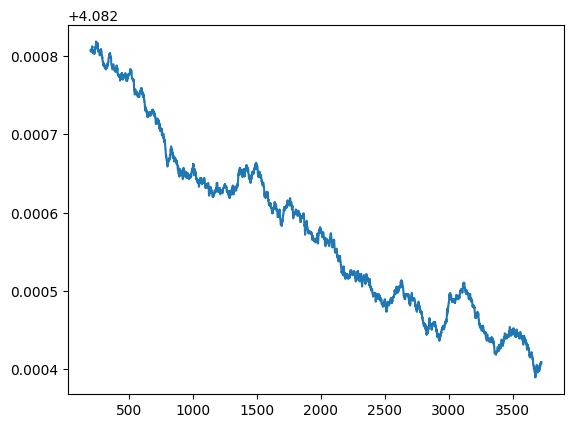

{'1 + dlnf/dlnc': 1.0,
 'Ambient temperature [K]': 298.15,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': 0.4,
 'Cell capacity [A.h]': 0.680616,
 'Cell cooling surface area [m2]': 0.0569,
 'Cell volume [m3]': 7.8e-06,
 'Current function [A]': Interpolant(0x6904c9f325e64b28, interpolating function, children=['time * 22598.609352346717'], domain=[], auxiliary_domains={}),
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Edge heat transfer coefficient [W.m-2.K-1]': 0.3,
 'Electrode height [m]': 0.137,
 'Electrode width [m]': 0.207,
 'Electrolyte conductivity [S.m-1]': InputParameter(-0x4a24fb173ab50899, Electrolyte conductivity [S.m-1], children=[], domain=[], auxiliary_domains={}),
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_Capiglia1999 at 0x000001E727BB7640>,
 'Initial concentration in electrolyte [mol.m-3]': 1000.0,
 'Initial concentration in negative electrode [mol.m-3]': 199

In [85]:
# import drive cycle from file
drive_cycle = pd.read_csv(
    "data_no_load.csv",
    header=0
)
drive_cycle.iloc[:,2] *= -1.0
drive_cycle.iloc[:,1] = drive_cycle.iloc[:,1].rolling(200).mean()
drive_cycle = drive_cycle.dropna(how='any')
drive_cycle.iloc[:,0] -= drive_cycle.iloc[0,0]
plt.plot(drive_cycle.iloc[:,1])
plt.show()
drive_cycle = drive_cycle.to_numpy()
N = len(drive_cycle)

timescale = param.evaluate(model.timescale)
current_interpolant = pybamm.Interpolant(drive_cycle[:,[0,2]], pybamm.t * timescale)
voltage_interpolant = interp1d(drive_cycle[:,0], drive_cycle[:,1])
#current_interpolant = interp1d(drive_cycle[:,0], drive_cycle[:,1])

# set drive cycle
param["Current function [A]"] = current_interpolant
#param.process_model(model)
param.update( { k:"[input]" for k in param_list} )
param.process_model(model)
param.process_geometry(geometry)
print(param)


In [86]:
var = pybamm.standard_spatial_vars
var_pts = {var.x_n: 20, var.x_s: 20, var.x_p: 20, var.r_n: 10, var.r_p: 10}
mesh = pybamm.Mesh(geometry, model.default_submesh_types, var_pts)
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model)

t_eval = np.linspace(0, N-1, 10)
solver = pybamm.CasadiSolver(mode="fast")
solver.rtol = 1e-6
solver.atol = 1e-9

[   0.          391.55555556  783.11111111 1174.66666667 1566.22222222
 1957.77777778 2349.33333333 2740.88888889 3132.44444444 3524.        ]


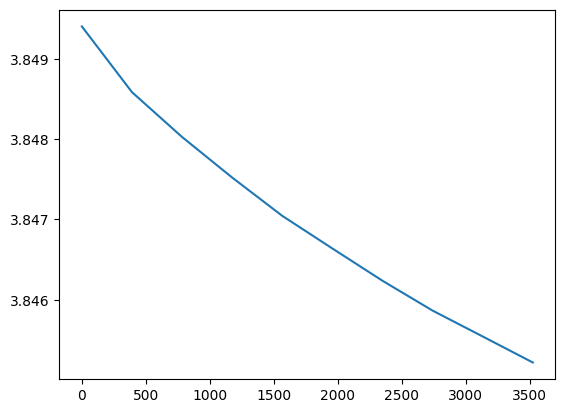

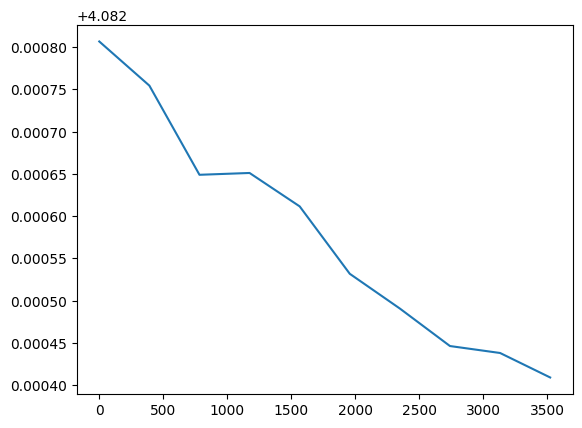

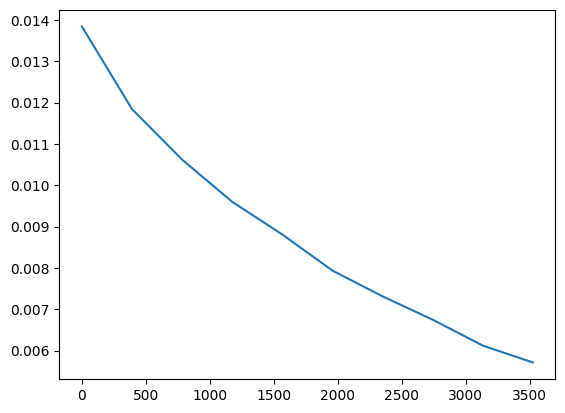

In [87]:
def objective(solution):
    return solution["Terminal voltage [V]"].entries

# Generate synthetic data, with noise
true_solution = solver.solve(
    model,
    t_eval,
    inputs={k:x0[i] for i,k in enumerate(param_list)},
)
data = objective(true_solution)
# add random normal noise
np.random.seed(42)
data_plus_noise = data + 0.01 * np.random.normal(size=data.shape[0]) / np.max(data)
current_data = true_solution['Current [A]'].entries
print(t_eval)
voltage_data = voltage_interpolant(t_eval)

plt.plot(t_eval, data)
plt.show()

plt.plot(t_eval, voltage_data)
plt.show()

plt.plot(t_eval, current_data)
plt.show()

In [88]:
def prediction_error(x):
    # Hack to enforce bounds
    print({k:x[i] for i,k in enumerate(param_list)})
    try:
        solution = solver.solve(
            model,
            t_eval,
            inputs={
                k:x[i] for i,k in enumerate(param_list)
            },
        )
    except pybamm.SolverError:
        print("error")
        return 1e5 * np.ones_like(voltage_data)
    prediction = objective(solution)
    # Crude way of making sure we always get an answer
    if len(prediction) != len(voltage_data):
        print("length mismatch")
        return 1e5 * np.ones_like(voltage_data)
    else:
        out = prediction 
        # print(x, np.linalg.norm(out))
        return out

In [89]:
# Do parameter fitting to find solution (using derivative-free library)

soln_lsq = least_squares(prediction_error, x0, verbose=2)
#soln_dfols = dfols.solve(prediction_error, x0)  # , bounds=(np.array([0]), None))

{'Electrolyte conductivity [S.m-1]': 0.3}
{'Electrolyte conductivity [S.m-1]': 0.3000000149011612}
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.3997e+01                                    1.13e+00    
{'Electrolyte conductivity [S.m-1]': 0.6}
{'Electrolyte conductivity [S.m-1]': 0.375}
{'Electrolyte conductivity [S.m-1]': 0.31875}
{'Electrolyte conductivity [S.m-1]': 0.3046875}
{'Electrolyte conductivity [S.m-1]': 0.301171875}
{'Electrolyte conductivity [S.m-1]': 0.30029296875}
{'Electrolyte conductivity [S.m-1]': 0.3000732421875}
{'Electrolyte conductivity [S.m-1]': 0.300018310546875}
{'Electrolyte conductivity [S.m-1]': 0.30000457763671873}
{'Electrolyte conductivity [S.m-1]': 0.3000011444091797}
{'Electrolyte conductivity [S.m-1]': 0.3000011593103409}
       1             11         7.3997e+01      4.34e-11       1.14e-06       8.77e+00    
{'Electrolyte conductivity [S.m-1]': 0.3000008583068848}
{'Elect

scipy.least_squares
--------------------
[0.30000114] [0.3]


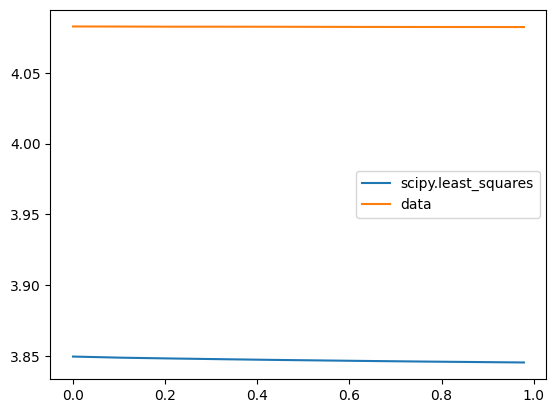

In [93]:
for algorithm, soln in [("scipy.least_squares", soln_lsq)]:
    print(algorithm)
    print("-" * 20)
    print(soln.x, x0)
    #print("-" * 20)
    found_solution = solver.solve(
        model,
        t_eval,
        inputs={
                k:soln.x[i] for i,k in enumerate(param_list)
        },
    )
    plt.plot(
        found_solution["Time [h]"].entries,
        found_solution["Terminal voltage [V]"].entries,
        label=algorithm,
    )

    # Plot
    plt.plot(true_solution["Time [h]"].entries, voltage_data, label="data")
    plt.legend()
    plt.show()

In [91]:
model.parameters

[InputParameter(-0x4a24fb173ab50899, Electrolyte conductivity [S.m-1], children=[], domain=[], auxiliary_domains={})]

In [92]:
pybamm.t

Time(-0x3d566004335a4a3f, time, children=[], domain=[], auxiliary_domains={})